In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [80]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [3]:
import fastparquet
%time df=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 2.12 s, sys: 1.15 s, total: 3.27 s
Wall time: 3.53 s


In [4]:
print df.shape
df=df[df['target']>=0]
print df.shape

(6582476, 52)
(5203955, 52)


In [5]:
X=df.drop(['target','fold'],axis=1)
y=df['target']

In [6]:
X_train=X[df['fold']<>0]
y_train=y[df['fold']<>0]
X_valid=X[df['fold']==0]
y_valid=y[df['fold']==0]

In [7]:
from sklearn.linear_model import ElasticNet,LinearRegression

# single model

In [8]:
#regr = ElasticNet(alpha=0)

In [9]:
regr=LinearRegression()

In [10]:
%time regr.fit(X_train, y_train)

CPU times: user 14.5 s, sys: 14.2 s, total: 28.7 s
Wall time: 2.82 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
qwk_score(y_train,regr.predict(X_train))

RMSE 1.94085


0.7246374423412365

In [22]:
qwk_score(y_valid,regr.predict(X_valid))

RMSE 1.94259


0.7235177491475742

In [13]:
regr.score(X_valid,y_valid)

0.5717577932825243

In [62]:
y_valid_pred=regr.predict(X_valid)

In [63]:
y_valid_pred.mean(),y_valid.mean(),y_valid_pred.var(),y_valid.var()

(4.5923142, 4.5899376165249963, 5.0570698, 8.8119518079477288)

In [75]:
qwk_score(y_valid,y_valid_pred)

RMSE 1.94259


0.7235177491475742

In [86]:
b=y_valid.var();a= (y_valid_pred).var();c=np.cov(y_valid,y_valid_pred)[0,1]
a,b,c

(5.0570698, 8.8119518079477288, 5.0476912487850543)

In [8]:
import numpy as np
5.0570698/np.sqrt(5.0476912487850543* 8.81195180794614), \
np.sqrt(0.65)

(0.75825712524341815, 0.80622577482985502)

In [88]:
pred_mean=y_valid_pred.mean()

In [87]:
beta=np.sqrt(b/a)
beta

1.3200384564020617

In [89]:
2*beta*c/(b+beta**2*a),qwk_score(y_valid,beta*(y_valid_pred-pred_mean)+pred_mean)

(0.75614877494345267, 0.753111475245815)

0.75319836082


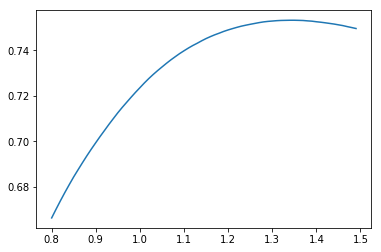

In [90]:
lst=[]
for i in np.arange(0.8,1.5,0.01):
    lst.append(qwk_score(y_valid,i*(y_valid_pred-pred_mean)+pred_mean))
plt.plot(np.arange(0.8,1.5,0.01),lst)  
print np.max(lst)

In [102]:
preds=[]
for _ in range(5):
    idx=np.random.choice(range(len(X_train)),len(X_train))
    X_train_bag=X_train.iloc[idx]
    y_train_bag=y_train.iloc[idx]
    print X_train_bag.shape,y_train_bag.shape
    regr=LinearRegression()
    regr.fit(X_train_bag,y_train_bag)
    print qwk_score(y_train_bag,regr.predict(X_train_bag))
    preds.append(regr.predict(X_valid))
                         

(4162333, 50) (4162333,)
0.724743061428
(4162333, 50) (4162333,)
0.724708052849
(4162333, 50) (4162333,)
0.724772885848
(4162333, 50) (4162333,)
0.724900698341
(4162333, 50) (4162333,)
0.725352960854


In [175]:
def scale(y_true,y_pred):
    m=y_pred.mean()
    beta=np.std(y_true)/np.std(y_pred)
    if np.corrcoef(y_true,y_pred)[0,1]<0:
        beta=-beta
    return beta*(y_pred-m)+m
def scaled_qwk_score(y_true,y_pred):
    return qwk_score(y_true,scale(y_true,y_pred))

In [114]:
for pred in preds:
    print qwk_score(y_valid,pred),qwk_score(y_valid,scale(y_valid,pred)),pred.std()


0.723511047015 0.753114210043 2.24873
0.723494971768 0.753075903586 2.24895
0.723540222256 0.753078080483 2.24951
0.72347425021 0.753080568379 2.24861
0.723621495114 0.75311669561 2.24953


In [115]:
pred_mean=np.mean(preds,0)
print qwk_score(y_valid,pred_mean),qwk_score(y_valid,scale(y_valid,pred_mean)),pred_mean.std()


0.723543402984 0.753113149595 2.24905


In [117]:
np.array(preds).shape

(5, 1041622)

In [119]:
pd.DataFrame(np.array(preds).T).corr()

0         1         2         3         4
0  1.000000  0.999982  0.999976  0.999985  0.999985
1  0.999982  1.000000  0.999970  0.999984  0.999984
2  0.999976  0.999970  1.000000  0.999986  0.999952
3  0.999985  0.999984  0.999986  1.000000  0.999972
4  0.999985  0.999984  0.999952  0.999972  1.000000

# cv

In [37]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import  make_scorer

In [29]:
regr=LinearRegression()

In [38]:
scorer=make_scorer(qwk_score)
scores = cross_val_score(regr, X.values, y.values, cv=KFold(5,shuffle=True), scoring=scorer)

RMSE 1.94312
RMSE 1.94064
RMSE 1.94178
RMSE 1.93789
RMSE 1.94286


In [41]:
print("qwk: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

qwk: 0.712 (+/- 0.001)


In [42]:
scores

array([ 0.71158859,  0.71233361,  0.71141741,  0.71239382,  0.71133211])

In [91]:
from sklearn.model_selection import cross_val_predict

In [120]:
import gc
gc.collect()

646

# something

In [121]:
yy=np.random.choice(y.values,10000)

## tip: scale. The smaller correlation, the more benefit

In [188]:
means=[0,0]
stds = [5,5]
corr = 0.0         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
a,b = np.random.multivariate_normal(means, covs, 10000).T
p1=yy+a
p2=yy+b
print np.corrcoef(p1,p2),p1.var(),p2.var()
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)

[[ 1.          0.25236962]
 [ 0.25236962  1.        ]] 33.6158351026 33.7442873075
non-scaled 0.450050836279 0.451124487662 0.61692669265
    scaled 0.508240954663 0.509738200116 0.644343211621


In [201]:
means=[0,0]
stds = [3,3]
corr = 0.0         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
a,b = np.random.multivariate_normal(means, covs, 10000).T
p1=yy+a
p2=yy+b
p1=clip_pred(p1)
p2=clip_pred(p2)
print np.corrcoef(p1,p2),p1.var(),p2.var(),yy.var(),np.std((p1+p2)/2)
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)

[[ 1.          0.51353021]
 [ 0.51353021  1.        ]] 14.50328775 14.78355616 8.85785279 3.32817177441
non-scaled 0.688180359969 0.691744786783 0.812496680731
    scaled 0.70425828375 0.71121564467 0.813200007166


In [208]:
means=[0,0]
stds = [4,4]
corr = 0.0         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
a,b = np.random.multivariate_normal(means, covs, 10000).T
p1=yy+a
p2=yy+b
p1=clip_pred(p1)
p2=clip_pred(p2)
print np.corrcoef(p1,p2),p1.var(),p2.var(),yy.var(),np.std((p1+p2)/2)
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)
p1=(p1-yy.mean())/p1.std()*yy.std()+yy.mean()
p2=(p2-yy.mean())/p2.std()*yy.std()+yy.mean()
print np.corrcoef(p1,p2),p1.var(),p2.var(),yy.var(),np.std((p1+p2)/2)
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)

[[ 1.          0.36217098]
 [ 0.36217098  1.        ]] 18.76915631 18.27977239 8.85785279 3.53928498994
non-scaled 0.555378608095 0.559023737811 0.71368589467
    scaled 0.587330625499 0.587160371479 0.722890764846
[[ 1.          0.36217098]
 [ 0.36217098  1.        ]] 8.85785279 8.85785279 8.85785279 2.45620744136
non-scaled 0.595336731492 0.59409682733 0.708396059152
    scaled 0.595336731492 0.59409682733 0.719803617995


In [190]:
means=[0,0]
stds = [1,1]
corr = 0.0         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
a,b = np.random.multivariate_normal(means, covs, 10000).T
p1=yy+a
p2=yy+b
print np.corrcoef(p1,p2),p1.var(),p2.var()
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)

[[ 1.         0.8963797]
 [ 0.8963797  1.       ]] 9.75504493304 9.84465574957
non-scaled 0.943452022708 0.943833043885 0.968489379616
    scaled 0.943193362909 0.943718996377 0.968374565526


## tip: for different predictions, estimate residuals cross correlation, then calculate optimal weights, then centralize, then scale

In [210]:
means=[0,0]
stds = [4,2]
corr = 0.0         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
a,b = np.random.multivariate_normal(means, covs, 10000).T
p1=yy+a
p2=yy+b
p1=clip_pred(p1)
p2=clip_pred(p2)
print np.corrcoef(p1,p2),p1.var(),p2.var(),yy.var(),np.std((p1+p2)/2)
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)
p1=(p1-yy.mean())/p1.std()*yy.std()+yy.mean()
p2=(p2-yy.mean())/p2.std()*yy.std()+yy.mean()
print np.corrcoef(p1,p2),p1.var(),p2.var(),yy.var(),np.std((p1+p2)/2)
print "non-scaled", qwk_score(yy,p1),qwk_score(yy,p2),qwk_score(yy,(p1+p2)/2)
print "    scaled", scaled_qwk_score(yy,p1),scaled_qwk_score(yy,p2),scaled_qwk_score(yy,(p1+p2)/2)

[[ 1.         0.5067981]
 [ 0.5067981  1.       ]] 18.74189271 11.68757904 8.85785279 3.36790022269
non-scaled 0.555572392519 0.829889309753 0.802684894657
    scaled 0.585440935948 0.835860507276 0.805415831775
[[ 1.         0.5067981]
 [ 0.5067981  1.       ]] 8.85785279 8.85785279 8.85785279 2.58331141444
non-scaled 0.593188522656 0.835860507276 0.813984075594
    scaled 0.593188522656 0.835860507276 0.821070072597


## tip: clip then align then scale

In [184]:
a=np.random.normal(loc=7,scale=1,size=len(yy))+0.1*yy
print a.mean(),yy.mean(),np.corrcoef(a,yy)[0,1]
print "non-scaled", qwk_score(yy,a)
print "    scaled", scaled_qwk_score(yy,a)
print "####"
a=clip_pred(a)
a=a-a.mean()+yy.mean()
print "non-scaled", qwk_score(yy,a)
print "    scaled", scaled_qwk_score(yy,a)

7.44951696252 4.5561 0.276871352238
non-scaled 0.0941558776388
    scaled 0.185551269472
####
non-scaled 0.172429354271
    scaled 0.269383257434
